In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from scipy import stats

# clustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# clustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

#Outlier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

#Feature Selection
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE


#Classifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, classification_report

#Timing classification
import time

In [2]:
# upload UCI_Credit_Card.csv to files
data = pd.read_csv('UCI_Credit_Card.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


# Data Preprocessing

In [3]:
# check if any missing information is present in a csv file.

#Number of rows before
print(f"Number of Rows before cleaning: {data.shape[0]}")

#Clean data
data = data.dropna()

#Check number of rows after:

print(f"Number of Rows after cleaning: {data.shape[0]}")

# should we also remove 0 values for certain attributes?
# Looking at the scatter plots, it looks like some values of 0 make analysis
# harder.

Number of Rows before cleaning: 30000
Number of Rows after cleaning: 30000


There are no values in the dataset that are missing in the form of NA

In [4]:
# Drop duplicates
#Number of rows before
print(f"Number of rows before removing duplicates: {data.shape[0]}")

duplicate_count = data.duplicated().sum()

print(f"Number of duplicates: {duplicate_count}")

if(duplicate_count == 0):
  print("no duplicates")

else:
  data = data.drop_duplicates()
  print(f"Number of rows after removing duplicates: {data.shape[0]}")

Number of rows before removing duplicates: 30000
Number of duplicates: 0
no duplicates


We have dropped data rows that do not make sense (Example: Marriage that is listed as 1 = married, 2 = single, 3 = others, but some rows had 0. We were unsure what this meant so the rows that had it were droppped.)

In [5]:
#Drop odd values in categorical values
print(f"Number of rows before removing odd rows: {data.shape[0]}")

data = data[data['MARRIAGE'].isin([1,2,3])]
data = data[data['EDUCATION'].isin([1,2,3,4,5,6])]
data = data[data['SEX'].isin([1,2])]

pay_list = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

for pay in pay_list:
  # -2 is assumed to be no credit to pay
  # -1 is credit paid fully
  # 0 is assumed to be payment made on time (minimum satement)
  data = data[data[pay].isin(range(-2,10))]


print(f"Number of rows after removing odd rows: {data.shape[0]}")

Number of rows before removing odd rows: 30000
Number of rows after removing odd rows: 29932


In [6]:
# one-hot encoding of categorical features
cat_cols = ['MARRIAGE']
data[cat_cols] = data[cat_cols].astype('category')
data = pd.get_dummies(data, columns=cat_cols, dtype=int)

In [7]:
# See new column names
print(data.columns.tolist())

# Compare before/after shape
print("Shape after encoding:", data.shape)

data.head()

data.to_csv('preprocessed_data.csv')

['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3']
Shape after encoding: (29932, 27)


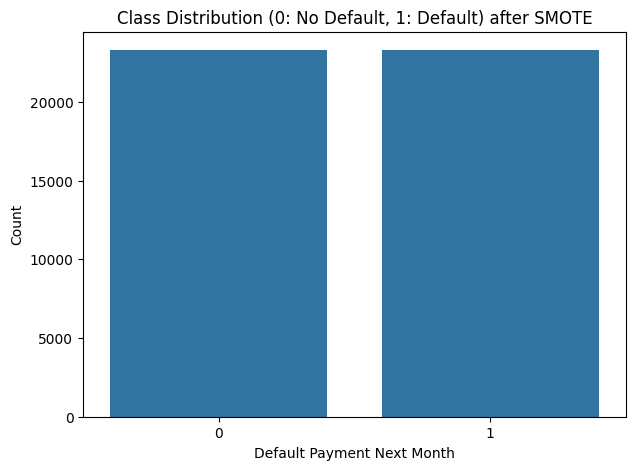

default.payment.next.month
1    23301
0    23301
Name: count, dtype: int64


,ID,LIMIT_BAL,SEX,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,default.payment.next.month
0,1,20000.0,2,2,24,2,2,-1,-1,-2,...,0.0,689.0,0.0,0.0,0.0,0.0,1,0,0,1
1,2,120000.0,2,2,26,-1,2,0,0,0,...,0.0,1000.0,1000.0,1000.0,0.0,2000.0,0,1,0,1
2,3,90000.0,2,2,34,0,0,0,0,0,...,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,1,0,0
3,4,50000.0,2,2,37,0,0,0,0,0,...,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,1,0,0,0
4,5,50000.0,1,2,57,-1,0,-1,0,0,...,2000.0,36681.0,10000.0,9000.0,689.0,679.0,1,0,0,0


In [8]:
# Data augmentation generating synthetic samples
# use SMOTE to solve class imbalance problem
x = data.drop('default.payment.next.month', axis=1)
y = data['default.payment.next.month']
smote=SMOTE(sampling_strategy='minority', random_state=42)
x,y=smote.fit_resample(x,y)
plt.figure(figsize=(7,5))
sns.countplot(x=y)
plt.title('Class Distribution (0: No Default, 1: Default) after SMOTE')
plt.xlabel('Default Payment Next Month')
plt.ylabel('Count')
plt.show()
print(y.value_counts())
data = pd.concat([x, y], axis=1)
data.head()

In [9]:
# Normalization/Standardization of data
scaler = StandardScaler()
num_cols = ['LIMIT_BAL','AGE'] + [f'BILL_AMT{i}' for i in range(1,7)] + [f'PAY_AMT{i}' for i in range(1,7)]
data[num_cols].describe().T[['mean', 'std']]

,mean,std
LIMIT_BAL,153471.321447,125705.256440
AGE,35.384983,8.800554
BILL_AMT1,50049.928509,73389.635716
BILL_AMT2,48384.255655,71233.040488
BILL_AMT3,46423.306642,69205.366988
BILL_AMT4,42894.225139,64402.148520
BILL_AMT5,40094.228248,61123.471881
BILL_AMT6,38768.348757,59773.451024
PAY_AMT1,4748.573797,14119.029807
PAY_AMT2,4922.841142,19492.488034


In [10]:
data[num_cols] = scaler.fit_transform(data[num_cols])
data[num_cols].describe().T[['mean', 'std']]

,mean,std
LIMIT_BAL,-7.318581e-17,1.000011
AGE,4.391149e-17,1.000011
BILL_AMT1,6.952652e-17,1.000011
BILL_AMT2,9.880084e-17,1.000011
BILL_AMT3,1.951622e-17,1.000011
BILL_AMT4,-2.515762e-17,1.000011
BILL_AMT5,9.026250e-17,1.000011
BILL_AMT6,2.317551e-17,1.000011
PAY_AMT1,1.707669e-17,1.000011
PAY_AMT2,-2.439527e-18,1.000011


In [11]:
# save preprocessed data to csv file
data.to_csv('preprocessed_data.csv', index=False)

### Read Preprocseed Data ###

In [12]:
data = pd.read_csv('preprocessed_data.csv')

# Clustering

C:\Users\Preston\AppData\Local\Temp\ipykernel_9724\4250305936.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\Preston\AppData\Local\Temp\ipykernel_9724\4250305936.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


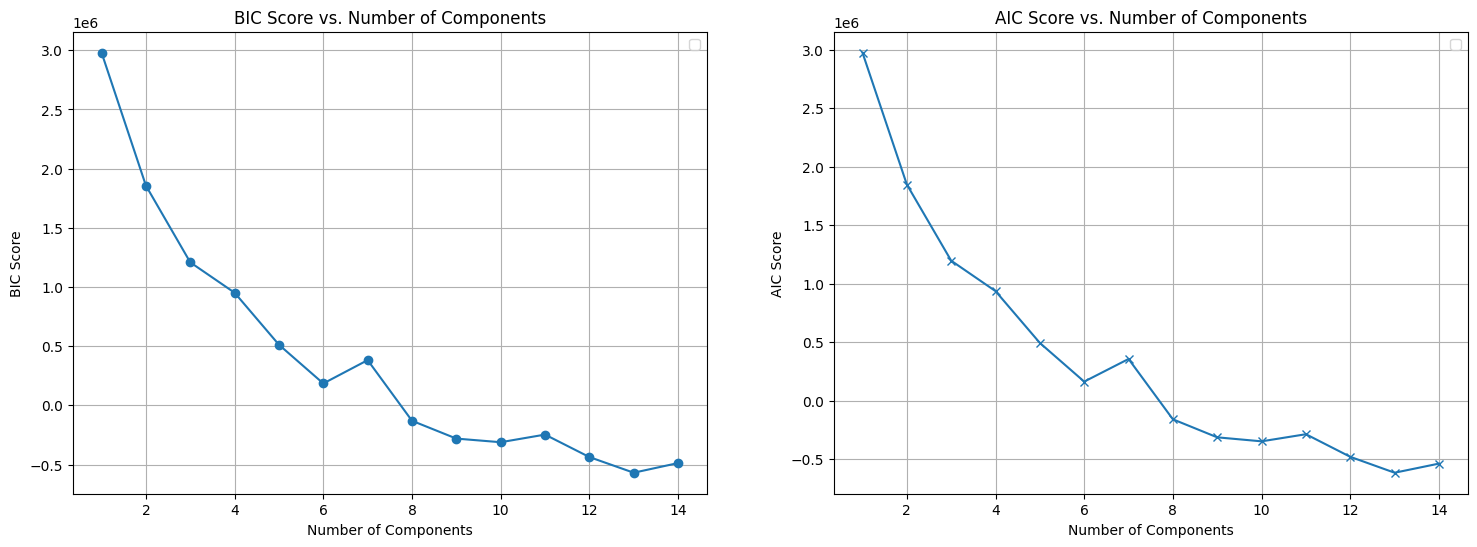

In [37]:
# Find optimal number of components using BIC and AIC
n_components = np.arange(1, 15)
bic_scores = []
aic_scores = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(data)
    bic_scores.append(gmm.bic(data))
    aic_scores.append(gmm.aic(data))

# Plot the BIC and AIC scores
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(n_components, bic_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC Score vs. Number of Components')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(n_components, aic_scores, marker='x')
plt.xlabel('Number of Components')
plt.ylabel('AIC Score')
plt.title('AIC Score vs. Number of Components')
plt.grid(True)
plt.legend()
plt.show()

In [38]:
# set up components needed for clustering
X_clustering = data.drop(['ID', 'default.payment.next.month'], axis=1)

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_clustering)

tsne = TSNE(n_components=2)
tsne_components = tsne.fit_transform(X_clustering)

def visualize_cluster(components, cluster_labels, title):
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=components[:, 0], y=components[:, 1], hue=cluster_labels, palette='viridis', s=50)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(title='Cluster')
    plt.show()

Clustering Method 1: Probabilistic Clustering - GMM

Clustering Performance Metrics:
Silhouette Score: 0.1206
Calinski-Harabasz Index: 2540.4517
Davies-Bouldin Index: 3.6517


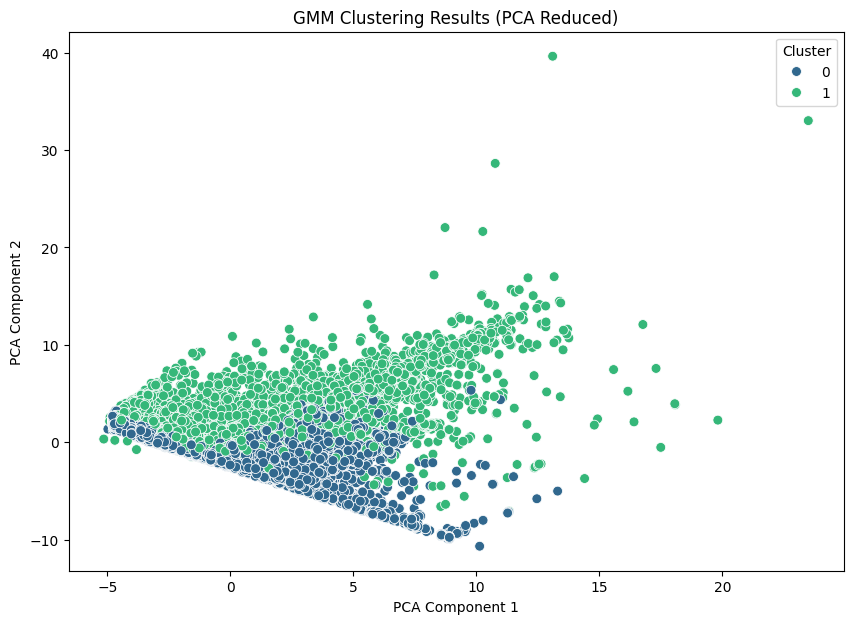


Cluster Means:
         LIMIT_BAL       SEX  EDUCATION       AGE     PAY_0     PAY_2  \
cluster                                                                 
0        -0.226216  1.497963   1.776637 -0.020616  0.290110  0.136621   
1         0.479178  1.524724   1.739110  0.043669 -0.075209 -0.168351   

            PAY_3     PAY_4     PAY_5     PAY_6  ...  BILL_AMT6  PAY_AMT1  \
cluster                                          ...                        
0        0.090280  0.031178 -0.029630 -0.071453  ...  -0.173408 -0.191562   
1       -0.223352 -0.278689 -0.311542 -0.330880  ...   0.367318  0.405772   

         PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  MARRIAGE_1  \
cluster                                                                 
0       -0.151181 -0.178959 -0.188741 -0.184632 -0.183185    0.362068   
1        0.320236  0.379078  0.399798  0.391093  0.388029    0.408899   

         MARRIAGE_2  MARRIAGE_3  
cluster                          
0          0.419402  

In [39]:
# 1. Setup Data (Drop Target and ID for clustering)
# Ensure 'data' is your scaled/preprocessed dataframe
X_clustering = data.drop(['ID', 'default.payment.next.month'], axis=1)

# 2. Fit GMM
optimal_components = 2  # You can adjust this based on your BIC/AIC plots
gmm = GaussianMixture(n_components=optimal_components, random_state=42)
cluster_labels = gmm.fit_predict(X_clustering)

# 3. Assign Labels back to a copy of data for analysis
df_clusters = data.copy()
df_clusters['cluster'] = cluster_labels

# 4. Evaluate Performance
print("Clustering Performance Metrics:")
print(f"Silhouette Score: {silhouette_score(X_clustering, cluster_labels):.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(X_clustering, cluster_labels):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_clustering, cluster_labels):.4f}")

# 5. Visualize using PCA (2D)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_clustering)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=cluster_labels, palette='viridis', s=50)
plt.title('GMM Clustering Results (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

# 6. Cluster Means Summary (Fixing your previous error)
# Group by the new 'cluster' column we created in df_clusters
cluster_summary = df_clusters.groupby('cluster')[X_clustering.columns].mean()
print("\nCluster Means:")
print(cluster_summary)

Clustering Method 2: Hierarchical Clustering

best number of clusters:  2
best distance function:  euclidean
silhouette score:  0.9481251377801815


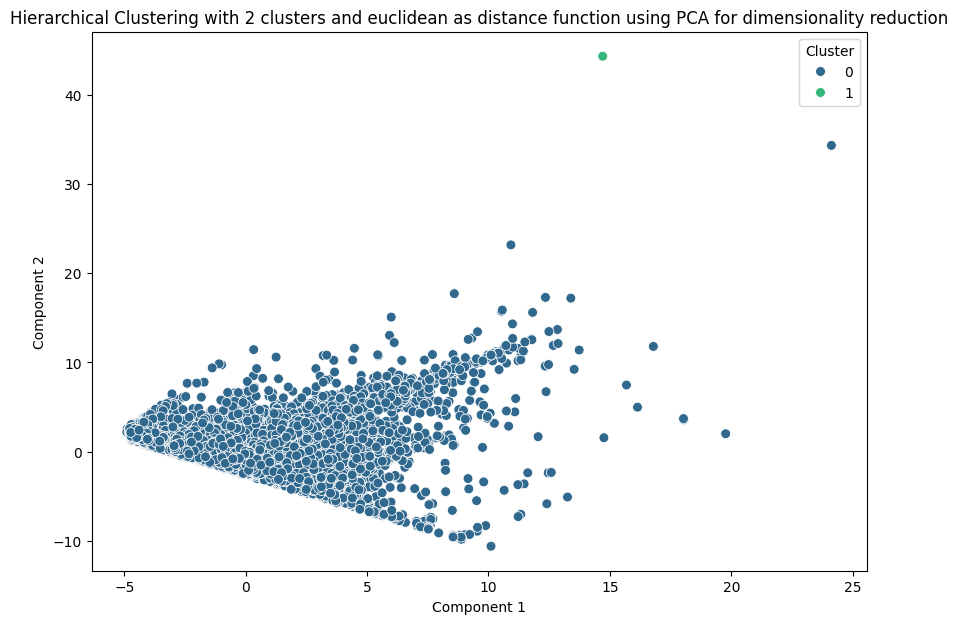

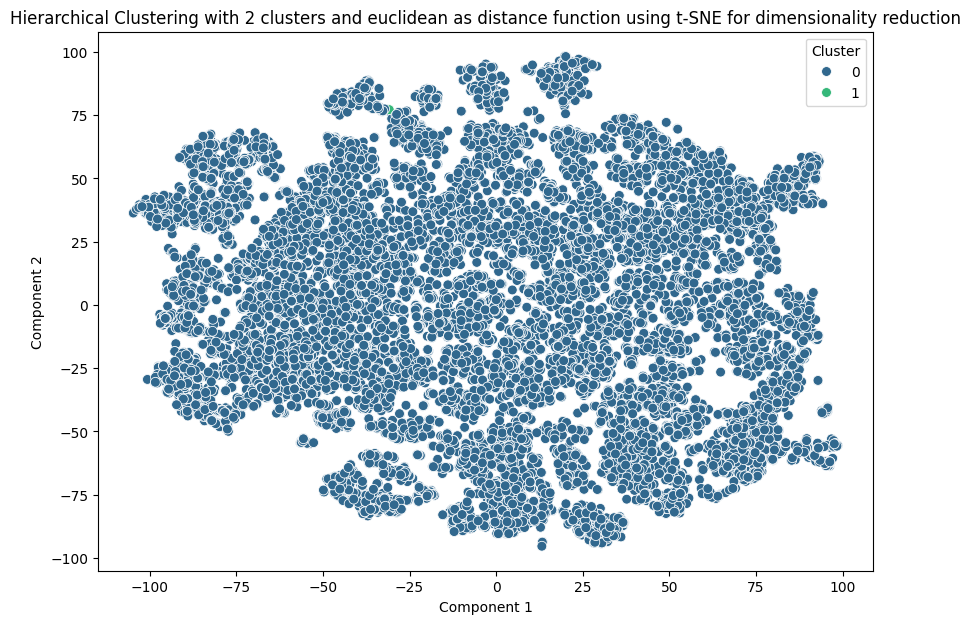

In [40]:
# for this clustering algorithm, the data is too large and must be reduced
n_clusters = np.arange(2, 11)
metrics = {'euclidean', 'manhattan', 'cosine'}
# linkages = {'ward', 'complete', 'average', 'single'}
best_silhouette = -1.0
best_labels = None
best_n = 2
# best_link = None
best_metric = None

# find best model using small sample
data_sub = pd.DataFrame(data).sample(20000, random_state=42) # Reduce to 20k samples
X_sub = data_sub.drop(['default.payment.next.month', 'ID'], axis=1)
y_sub = data_sub['default.payment.next.month']

for n in n_clusters:
    for m in metrics:
        clustering = AgglomerativeClustering(n_clusters=n, metric=m, linkage='complete')
        labels = clustering.fit_predict(X_sub)
        temp_silhouette_score = silhouette_score(X_sub, labels)
        if (temp_silhouette_score > best_silhouette):
            best_silhouette = temp_silhouette_score
            best_labels = labels
            best_n = n
            # best_link = l
            best_metric = m

print('best number of clusters: ', best_n)
print('best distance function: ', best_metric)
print('silhouette score: ', best_silhouette)

chart_X_sub = PCA(2).fit_transform(X_sub)

title = f"Hierarchical Clustering with {best_n} clusters and {best_metric} as distance function using PCA for dimensionality reduction"
visualize_cluster(chart_X_sub, best_labels, title)

# try with t-SNE
tsne_X_sub = TSNE(2).fit_transform(X_sub)
title_tsne = f"Hierarchical Clustering with {best_n} clusters and {best_metric} as distance function using t-SNE for dimensionality reduction"
visualize_cluster(tsne_X_sub, best_labels, title_tsne)

Despite the high silhouette score, it is clear that this clustering algorithm is not working well. Almost all of the data points are in one cluster except for one point that is far away. This is kind of meaningless.

Clustering Method 3: K-Means

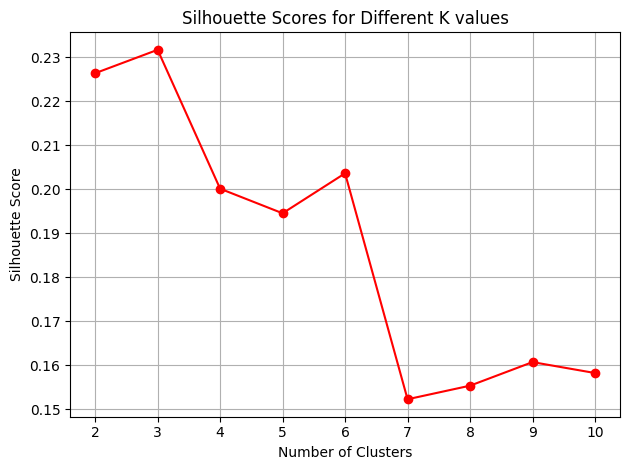

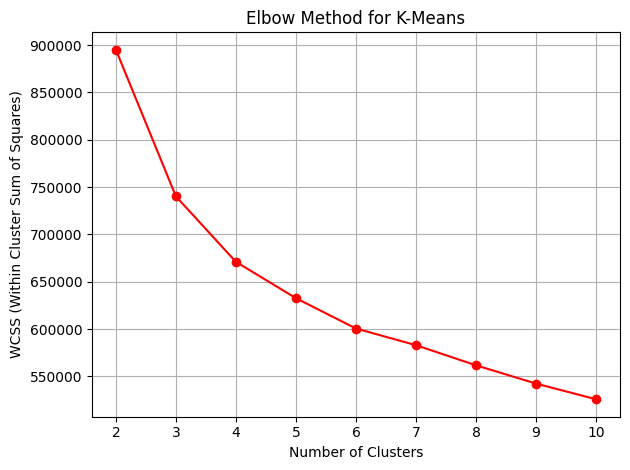

Cluster distribution:
Cluster
0    26285
1     5268
2    15049
Name: count, dtype: int64
Clustering Performance Metrics:
Silhouette Score: 0.2317
Calinski-Harabasz Index: 11297.9031
Davies-Bouldin Index: 1.4369


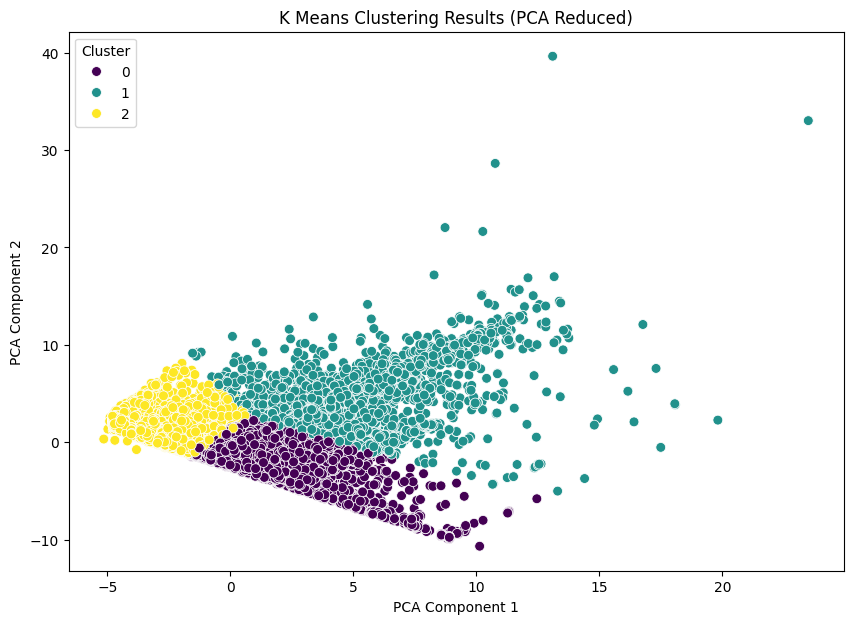

In [41]:
wcss = []
silhouette_scores = []
k_range = range(2, 11)
X_scaled = data.drop(['ID','default.payment.next.month'], axis=1)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

    # Calculate silhouette score
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plot Silhouette Scores Method + Elbow Method

plt.plot(range(2, 11), silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different K values')
plt.grid(True)

plt.tight_layout()
plt.show()


plt.plot(range(2, 11), wcss, 'ro-')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Elbow Method for K-Means')
plt.grid(True)

plt.tight_layout()
plt.show()

#Use Optimal k based on the results from the earlier k findings
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_clusters = kmeans.fit_predict(X_scaled)

#Add cluster labels to original dataframe
df_with_clusters = data.copy()
df_with_clusters['Cluster'] = kmeans_clusters

#Display performance metrics
print("Cluster distribution:")
print(df_with_clusters['Cluster'].value_counts().sort_index())

print("Clustering Performance Metrics:")
print(f"Silhouette Score: {silhouette_score(X_scaled, kmeans_clusters):.4f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score(X_scaled, kmeans_clusters):.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_scaled, kmeans_clusters):.4f}")

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=kmeans_clusters, palette='viridis', s=50)
plt.title('K Means Clustering Results (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

The main hyperparameter tested for this clustering algorithm is the number of clusters which ranges from 2 to 11. After testing, two plots were when analyzing the KMeans cluster. The first is the elbow method graph which measures the inertia (the sum squared distances between each data point and the centroid). Lower inertia implies the points are closer to their cluster centers. The graph is used to locate the "elbow point" of the curve which indicates where the rate of decrease inertia slows. This occurs between k = 2 and k = 3. So k = 3 is our point of interest.
Analyzing the silhouette graph we see that the graph peaks at k = 3 with a score of 0.2317, shows that the dataset contains 3 clusters. However the relatively low score implies the dataset does not have well-defined cluster boundaries. For future tests, testing algorithms like DBSCAN may capture more complex patterns of the dataset.

# Outlier Detection

In [18]:
def visualize_outliers(components, y_pred_outliers, title):
    plt.figure(figsize=(10, 7))
    # Plot inliers
    plt.scatter(components[y_pred_outliers == 1, 0], components[y_pred_outliers == 1, 1],
                c='blue', label='Inliers', s=50, alpha=0.6)
    # Plot outliers
    plt.scatter(components[y_pred_outliers == -1, 0], components[y_pred_outliers == -1, 1],
                c='red', label='Outliers', s=50, marker='x')

    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

In [19]:
#Estimate Contamination Level using z-scores. Outliers are considered as data points with score 3 or higher
z_scores = np.abs(stats.zscore(data))
estimated_contamination = np.mean(z_scores > 3)
print(f"Estimated Contamination Level: {estimated_contamination:.4f}")

Estimated Contamination Level: 0.0103


To have a rough estimate on where to start testing contamination levels for our outlier algorithms we decided to calcualte the approxiamte number of outliers based on the the z-score of the dataset which measures the number of standard deviations a data point is from the mean. Having a higher z-score implies that the data point is further from the mean compared to the average data point which can mean the data point is an outlier. 
s
We decided to take all data points with z-scores greater than 3 and divided the set by the total number of data points to get our estimated contamination score.
With a score of  0.0103, we decided to start from there and test different contamination levels.

Outlier Detection Method 1: Local Outlier Factor (LOF)

Number of outliers detected: 467
Number of inliers: 46135


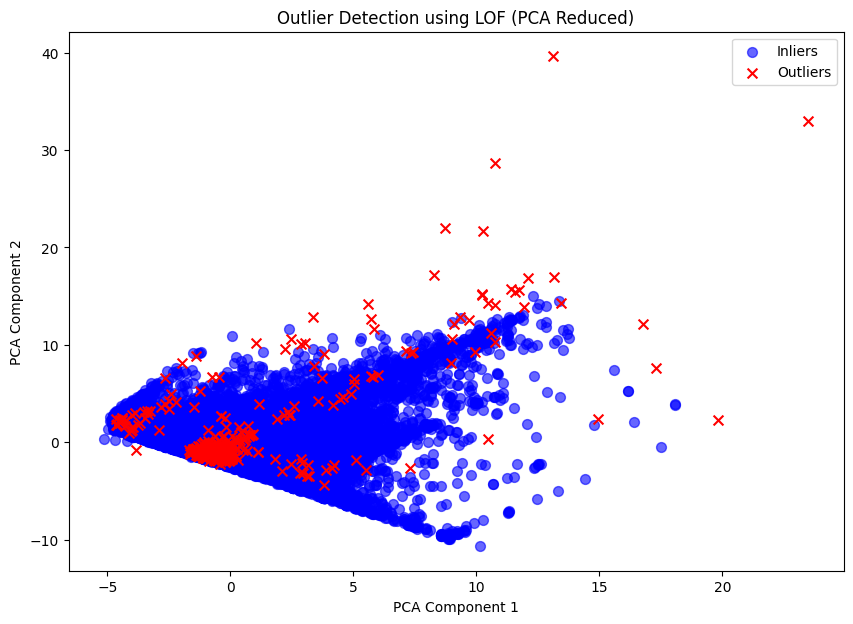

In [20]:

# 1. Create a COPY for outlier analysis (Keeps 'data' pure)
df_outliers = data.copy()

# 2. Fit LOF
# We use X_clustering again since it only has the features we want
lof = LocalOutlierFactor(n_neighbors=50, contamination=0.01)
y_pred_outliers = lof.fit_predict(X_clustering) # Returns -1 for outliers, 1 for inliers

# 3. Store results in the COPY
df_outliers['outlier_lof'] = y_pred_outliers

# Identify outlier/inlier sets from the copy
outliers = df_outliers[df_outliers['outlier_lof'] == -1]
inliers = df_outliers[df_outliers['outlier_lof'] == 1]

print(f"Number of outliers detected: {len(outliers)}")
print(f"Number of inliers: {len(inliers)}")

# 4. Visualize Outliers using PCA (Re-using pca_components from above)
plt.figure(figsize=(10, 7))
# Plot inliers
plt.scatter(pca_components[y_pred_outliers == 1, 0], pca_components[y_pred_outliers == 1, 1],
            c='blue', label='Inliers', s=50, alpha=0.6)
# Plot outliers
plt.scatter(pca_components[y_pred_outliers == -1, 0], pca_components[y_pred_outliers == -1, 1],
            c='red', label='Outliers', s=50, marker='x')

plt.title('Outlier Detection using LOF (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

Outlier Detection Method 2: Isolation Forset

In [21]:
# I read https://www.geeksforgeeks.org/machine-learning/anomaly-detection-using-isolation-forest/ for help
X = data.drop(['default.payment.next.month', 'ID'], axis=1)
y = data['default.payment.next.month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
contaminations = {0.01, 0.05, 0.1, 0.125, 0.15, 0.2}

chart_X_test = PCA(2).fit_transform(X_test)
tsne_X_test = TSNE(2).fit_transform(X_test)

for contamination in contaminations:
    clf = IsolationForest(contamination=contamination)
    clf.fit(X_train)

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    # uncomment to see what each algorithm looks like
    # title = f"Isolation Forest with contamination level: {contamination} using PCA"
    # visualize_cluster(chart_X_test, y_pred_test, title)
    # title_tsne = f"Isolation Forest with contamination level: {contamination} using t-SNE"
    # visualize_cluster(tsne_X_test, y_pred_test, title_tsne)

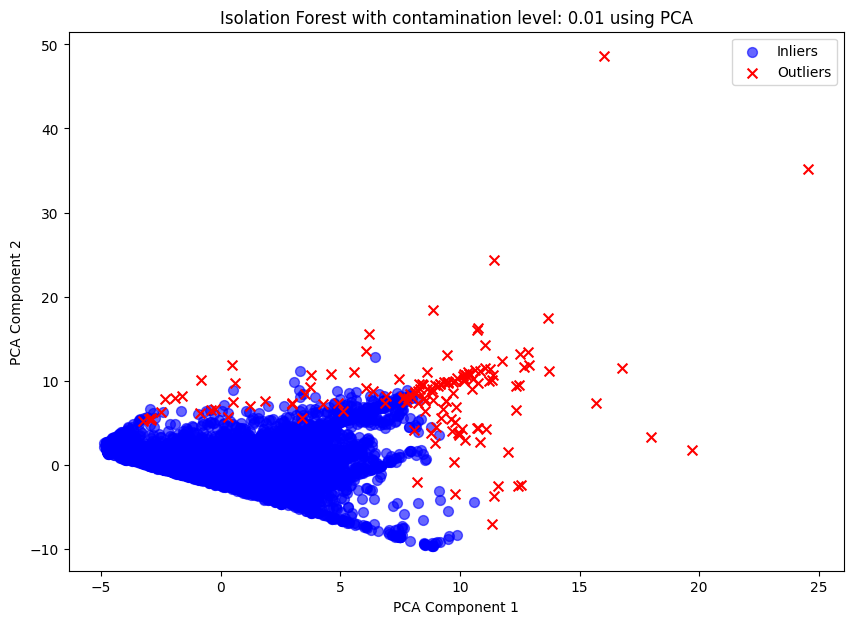

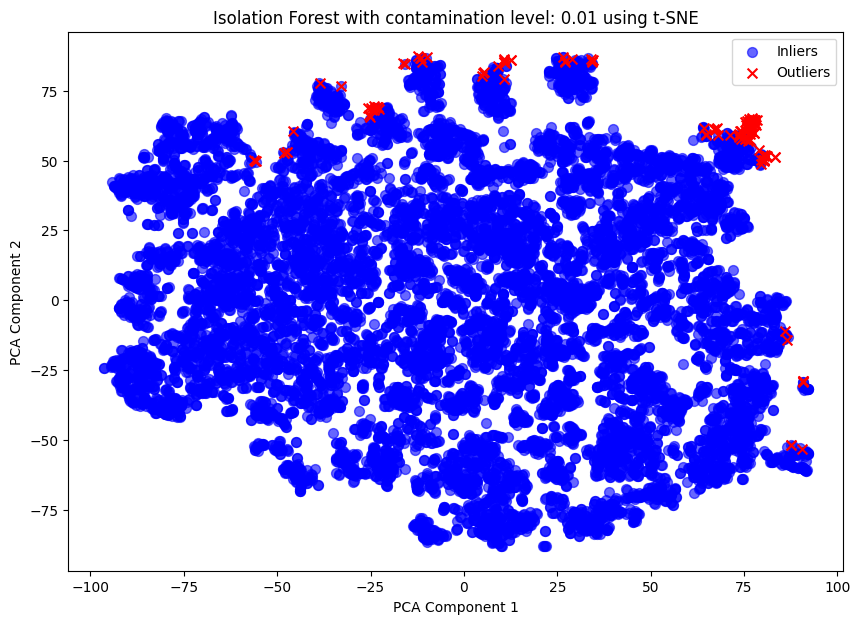

In [22]:
# 0.01 looked the best
contamination = 0.01
clf = IsolationForest(contamination=contamination)
clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

title = f"Isolation Forest with contamination level: {contamination} using PCA"
X_test_pca = PCA(2).fit_transform(X_test)
visualize_outliers(X_test_pca, y_pred_test, title)

title_tsne = f"Isolation Forest with contamination level: {contamination} using t-SNE"
X_test_tsne = TSNE(2).fit_transform(X_test)
visualize_outliers(X_test_tsne, y_pred_test, title_tsne)

After trying out different values for the contamination level, 0.01 looked the best. If the contaminatoin value was too high, there would be too many selected points.

Outlier Detection Method 3: Elliptic Envolope


--- Testing contamination = 0.01 ---
Number of outliers: 467
Number of inliers: 46135
Outlier percentage: 1.00%

--- Testing contamination = 0.02 ---
Number of outliers: 933
Number of inliers: 45669
Outlier percentage: 2.00%

--- Testing contamination = 0.03 ---
Number of outliers: 1399
Number of inliers: 45203
Outlier percentage: 3.00%

--- Testing contamination = 0.04 ---
Number of outliers: 1865
Number of inliers: 44737
Outlier percentage: 4.00%

--- Testing contamination = 0.05 ---
Number of outliers: 2331
Number of inliers: 44271
Outlier percentage: 5.00%

--- Testing contamination = 0.06 ---
Number of outliers: 2797
Number of inliers: 43805
Outlier percentage: 6.00%

--- Testing contamination = 0.07 ---
Number of outliers: 3263
Number of inliers: 43339
Outlier percentage: 7.00%

--- Testing contamination = 0.08 ---
Number of outliers: 3729
Number of inliers: 42873
Outlier percentage: 8.00%

--- Testing contamination = 0.09 ---
Number of outliers: 4195
Number of inliers: 42407
Ou

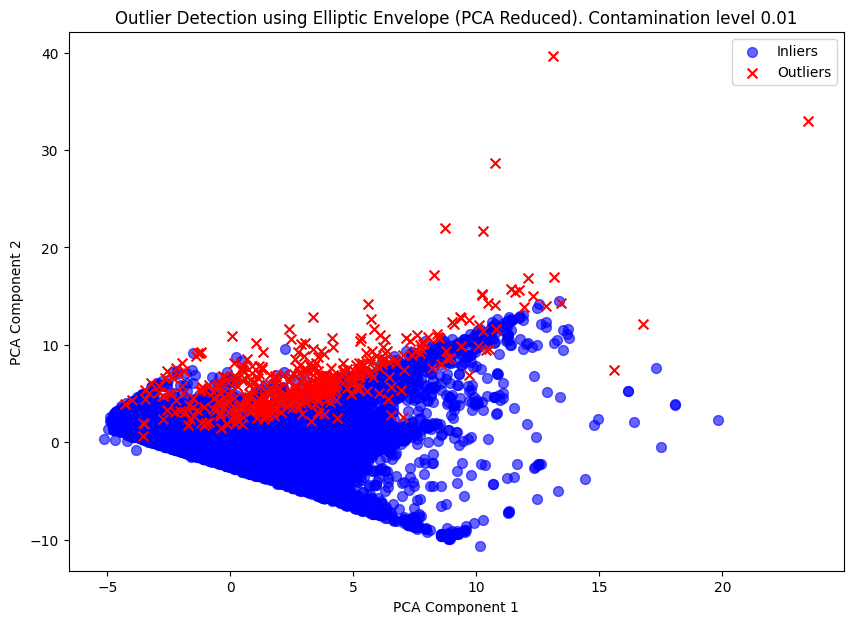

In [23]:

data_outliers = data.copy()
X_elliptic = data_outliers.drop(['ID', 'default.payment.next.month'], axis=1)
y_elliptic = data_outliers['default.payment.next.month']

outlier_results = {}

#Try other contamination levels
contamination_levels = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

for contamination in contamination_levels:
    print(f"\n--- Testing contamination = {contamination} ---")

    # Initialize Elliptic Envelope
    ee = EllipticEnvelope(contamination=contamination, random_state=42)

    # Fit and predict outliers (-1 for outliers, 1 for inliers)
    outlier_labels = ee.fit_predict(X_elliptic)

    data_outliers['outlier_ee'] = outlier_labels
    outliers_ee = data_outliers[data_outliers['outlier_ee'] == -1]
    inliers_ee = data_outliers[data_outliers['outlier_ee'] == 1]

    print(f'Number of outliers: {len(outliers_ee)}' )
    print(f'Number of inliers: {len(inliers_ee)}')
    print(f"Outlier percentage: {(len(outliers_ee)/len(data_outliers))*100:.2f}%")



    data_outliers = data_outliers.drop('outlier_ee', axis=1)

# Display best looking graph
# Initialize Elliptic Envelope
ee = EllipticEnvelope(contamination=0.01, random_state=42)

# Fit and predict outliers (-1 for outliers, 1 for inliers)
outlier_labels = ee.fit_predict(X_elliptic)

data_outliers['outlier_ee'] = outlier_labels
outliers_ee = data_outliers[data_outliers['outlier_ee'] == -1]
inliers_ee = data_outliers[data_outliers['outlier_ee'] == 1]

plt.figure(figsize=(10,7))
plt.scatter(pca_components[outlier_labels == 1, 0], pca_components[outlier_labels == 1, 1],
            c='blue', label='Inliers', s=50, alpha=0.6)
plt.scatter(pca_components[outlier_labels == -1, 0], pca_components[outlier_labels == -1, 1],
            c='red', label='Outliers', s=50,marker='x')
plt.title(f'Outlier Detection using Elliptic Envelope (PCA Reduced). Contamination level {0.01}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


11 different contamination levels were tested for elliptic envelopes which  range from 0.01 to 0.1. After visualizing the different contamination levels for elliptic envelopes, contamination level of 0.01 appears to have the best results as it grasps some outliers found in the scatter plot without including many false positives compared to the other tests. Despite this, Elliptic Envelope does not do a great job at detecting outliers as it already appears to include false outliers. 

Most data points flagged as outliers appear to be just data points found appears to be dependent on PCA Component 2 value where the higher value results in a higher chance of being flagged as an outlier. This is evident when looking at the scatterplot where the general data points labeled as outliers are found to be on the top sections of the cluster. Points such as (1,20) datapoint appears to be an outlier in the cluster but is not flagged. This may indicate that the dataset is too complex where reducing the 24-dimensional dataset to simply 2 dimensions results in Elliptic Envelope unable to create a correct fit.

# Feature Selection

Feature Selection Method 1: Lasso Regression

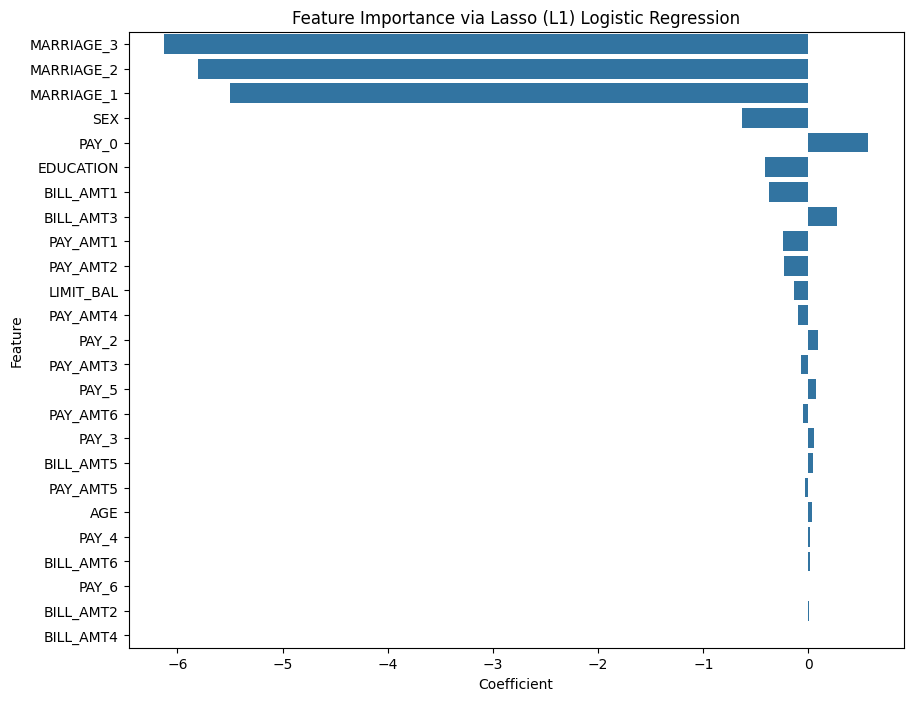

Selected Features (24): ['MARRIAGE_3', 'MARRIAGE_2', 'MARRIAGE_1', 'SEX', 'PAY_0', 'EDUCATION', 'BILL_AMT1', 'BILL_AMT3', 'PAY_AMT1', 'PAY_AMT2', 'LIMIT_BAL', 'PAY_AMT4', 'PAY_2', 'PAY_AMT3', 'PAY_5', 'PAY_AMT6', 'PAY_3', 'BILL_AMT5', 'PAY_AMT5', 'AGE', 'PAY_4', 'BILL_AMT6', 'PAY_6', 'BILL_AMT2']

Feature Coefficients:
| Feature    |   Coefficient |
|:-----------|--------------:|
| MARRIAGE_3 |   -6.12791    |
| MARRIAGE_2 |   -5.80011    |
| MARRIAGE_1 |   -5.49939    |
| SEX        |   -0.635672   |
| PAY_0      |    0.569757   |
| EDUCATION  |   -0.411571   |
| BILL_AMT1  |   -0.376536   |
| BILL_AMT3  |    0.271426   |
| PAY_AMT1   |   -0.240319   |
| PAY_AMT2   |   -0.231193   |
| LIMIT_BAL  |   -0.138508   |
| PAY_AMT4   |   -0.0954581  |
| PAY_2      |    0.0943853  |
| PAY_AMT3   |   -0.0722606  |
| PAY_5      |    0.0696008  |
| PAY_AMT6   |   -0.0546419  |
| PAY_3      |    0.0505683  |
| BILL_AMT5  |    0.0404385  |
| PAY_AMT5   |   -0.0342544  |
| AGE        |    0.0324914 

In [24]:
# 1. Prepare Train/Test Data
X = data.drop(['ID', 'default.payment.next.month', 'outlier_lof', 'cluster'], axis=1, errors='ignore')
y = data['default.payment.next.month']

# 2. Apply Lasso (L1 Penalty)
# solver='liblinear' is required for L1 penalty
lasso_sel = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42)
lasso_sel.fit(X, y)

# 3. Visualize Feature Importance (Coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_sel.coef_[0]
})
# Sort by absolute value of coefficient
feature_importance['Abs_Coef'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coef', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
plt.title('Feature Importance via Lasso (L1) Logistic Regression')
plt.show()

# 4. Select Features
# Keep features where coefficient is not 0
selected_feats = feature_importance[feature_importance['Abs_Coef'] > 0]['Feature'].tolist()
print(f"Selected Features ({len(selected_feats)}): {selected_feats}")

# Update X to use only selected features for classification
X_selected_Lasso = X[selected_feats]

# Printing Coefficients
print("\nFeature Coefficients:")
print(feature_importance[['Feature', 'Coefficient']].to_markdown(index=False))


Feature Selection Method 2: Mutual information

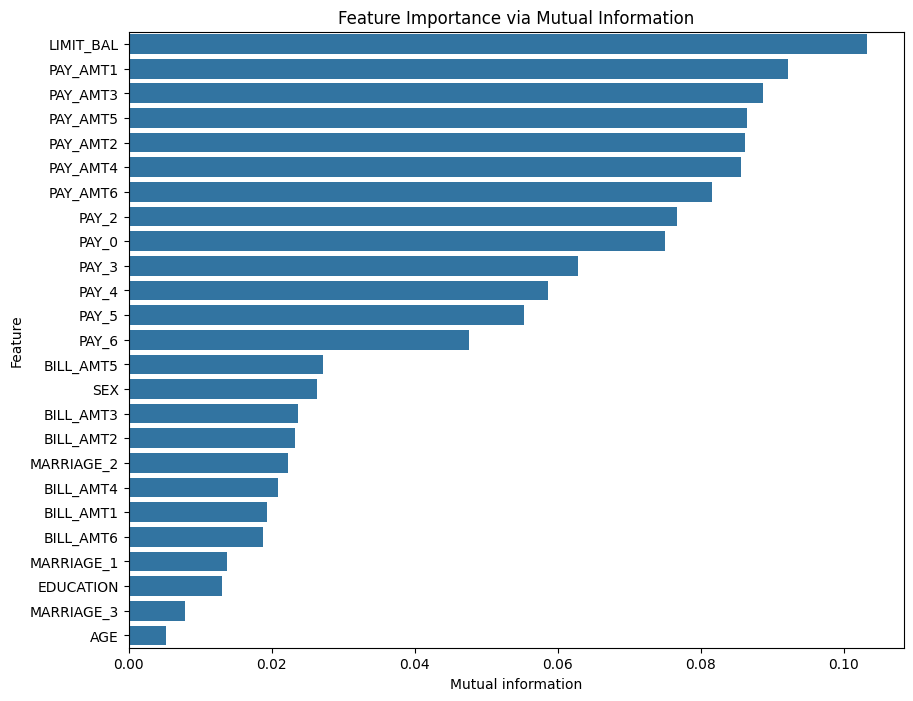

Selected Features (19): ['LIMIT_BAL', 'PAY_AMT1', 'PAY_AMT3', 'PAY_AMT5', 'PAY_AMT2', 'PAY_AMT4', 'PAY_AMT6', 'PAY_2', 'PAY_0', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT5', 'SEX', 'BILL_AMT3', 'BILL_AMT2', 'MARRIAGE_2', 'BILL_AMT4']


In [25]:
# X is feature matrix, y is target
X = data.drop(['default.payment.next.month', 'ID'], axis=1)
y = data['default.payment.next.month']

mi = mutual_info_classif(X, y, random_state=42)

# Convert MI scores into a readable format
mi_scores = pd.Series(mi, index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

feature_importance = pd.DataFrame({
    'Feature': mi_scores.index,
    'Mutual information': mi_scores
})

plt.figure(figsize=(10, 8))
sns.barplot(x='Mutual information', y='Feature', data=feature_importance)
plt.title('Feature Importance via Mutual Information')
plt.show()

# Keep features where mutual informatoin is greater than 0.02
selected_feats = feature_importance[feature_importance['Mutual information'] > 0.02]['Feature'].tolist()

print(f"Selected Features ({len(selected_feats)}): {selected_feats}")

# Update X to use only selected features for classification
X_selected_mi = X[selected_feats]

Most of the mutual information scores were similar to each other. `LIMIT_BAL` was the most informative and `AGE` was the least.

Feature Selection Method 3: RFE

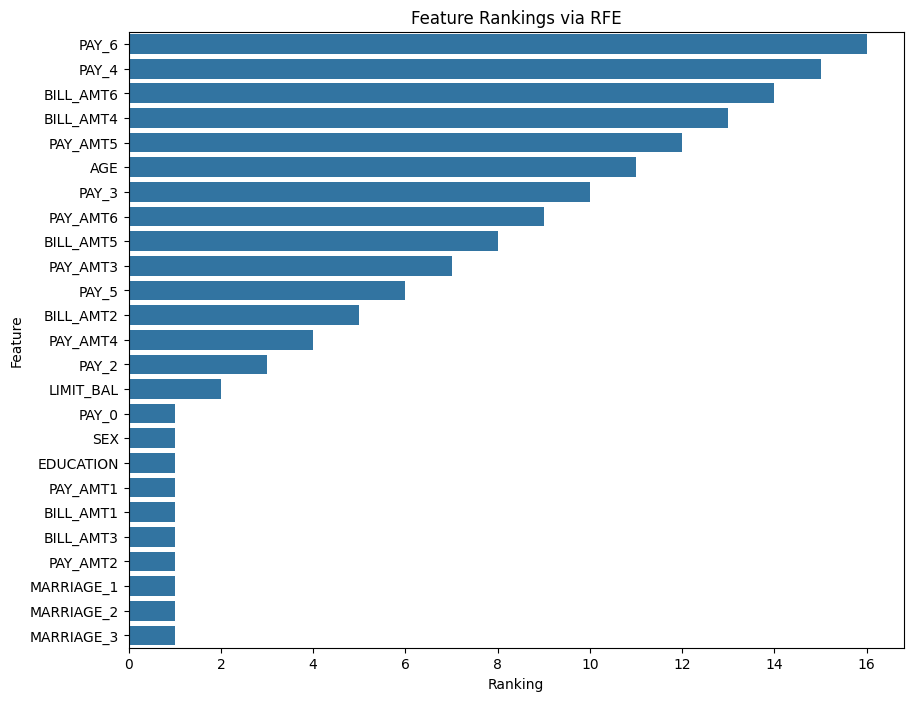

Removed Features (4): ['PAY_6', 'PAY_4', 'BILL_AMT6', 'BILL_AMT4']


In [26]:

X_RFE = data.drop(['ID', 'default.payment.next.month'], axis=1)
y_RFE = data['default.payment.next.month']

#Use logistic Regression as estimator

rfe_sel = RFE(estimator = LogisticRegression(random_state=42, max_iter=1000), n_features_to_select=10)
rfe_sel.fit(X_RFE,y_RFE)

#Rank the importance of each feature from 1 to n where 1 is the most important 
feature_importance = pd.DataFrame({
    'Feature' : X_RFE.columns,
    'Ranking' : rfe_sel.ranking_
})

feature_importance = feature_importance.sort_values(by='Ranking', ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x='Ranking', y='Feature', data=feature_importance)
plt.title('Feature Rankings via RFE')
plt.show()

selected_feats = feature_importance[feature_importance['Ranking'] >= 13]['Feature'].tolist()
print(f"Removed Features ({len(selected_feats)}): {selected_feats}")

X_selected_RFE = data.drop(['ID','default.payment.next.month', 'PAY_6','PAY_4','BILL_AMT6', 'BILL_AMT4'],axis=1)

Our goal is to find features that are the least impactful from the dataset and potentially remove them from the dataset for further analysis. This is through ranking each feature from 1 which represents the most impactful to n where n (an arbitrary large number) represents the least impactful. Because RFE requires a classifier to decide the ranking of the features, we decided to use logistic regression. 

Based on the tables, it appears PAY_6, PAY_4, BILL_AMT4, and BILL_AMT6 are the least ranked features in the dataset. This ranking can be attributed to what PAY_N and BILL_AMTN represents. Both variables represents the repayment status from N months (N-1 months for PAY_N) prior to September 2005. Older data for repayment status and bill statements are less impactful due to extraneous variables changing a person's habits within a period of time. In other words, more recent data of a person's payment/default status should in fact be more impactful compared to older data.

Selected Feature Removal:

In [27]:

X_removed_features = data.drop(['ID','default.payment.next.month', 'AGE', 'BILL_AMT4', 'BILL_AMT2', 'BILL_AMT5'],axis=1)
X_Regular = data.drop(['ID','default.payment.next.month'],axis=1)
y = data['default.payment.next.month']

Based on the feature selections algorithms performed. We notcied there were some common features that had displayed low scores or very low rankings. As a result, we decided to remove these features from the dataset and will tests the feature selected data vs regular data on the classifiers.

The features removed are PAY_6, PAY_4, BILL_AMT6, BILL_AMT4

# Classification

Classification Method 1: Random Forest

--------------------------------------------------
Training Random Forest on ALL Features
--------------------------------------------------
   [Full Features Results]
   Accuracy:  0.8593
   Precision: 0.8863
   Recall:    0.8254
   F1-Score:  0.8547
   AUC-ROC:   0.9254

5-Fold CV F1-Scores: [0.84710457 0.85055866 0.84169125 0.85386659 0.8418396 ]
Mean CV F1-Score: 0.8470


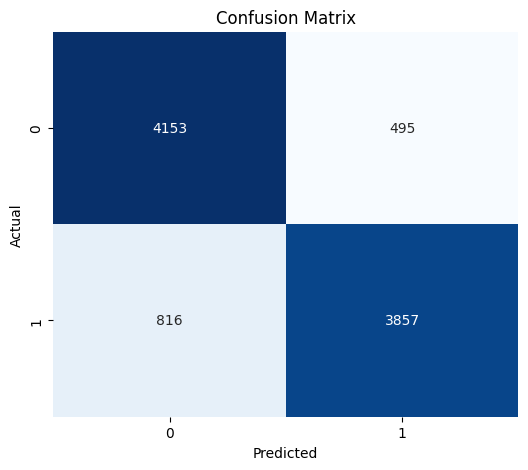

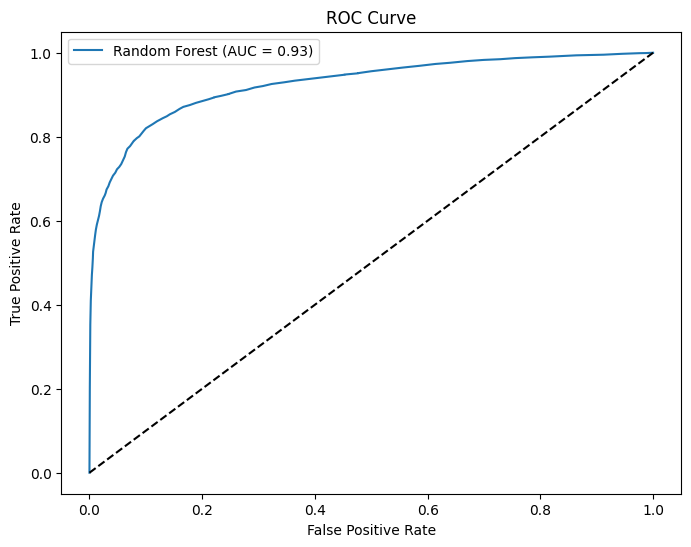

In [28]:

# Split Full Data
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_Regular, y, test_size=0.2, random_state=42)

# Train & Evaluate on FULL Features
print("-" * 50)
print("Training Random Forest on ALL Features")
print("-" * 50)
rf_full = RandomForestClassifier(random_state=42)
rf_full.fit(X_train_full, y_train_full)

y_pred_full = rf_full.predict(X_test_full)
y_prob_full = rf_full.predict_proba(X_test_full)[:, 1]

print("   [Full Features Results]")
print(f"   Accuracy:  {accuracy_score(y_test_full, y_pred_full):.4f}")
print(f"   Precision: {precision_score(y_test_full, y_pred_full):.4f}")
print(f"   Recall:    {recall_score(y_test_full, y_pred_full):.4f}")
print(f"   F1-Score:  {f1_score(y_test_full, y_pred_full):.4f}")
print(f"   AUC-ROC:   {roc_auc_score(y_test_full, y_prob_full):.4f}")

# Cross-Validation
cv_scores = cross_val_score(rf_full, X_train_full, y_train_full, cv=5, scoring='f1')
print(f"\n5-Fold CV F1-Scores: {cv_scores}")
print(f"Mean CV F1-Score: {cv_scores.mean():.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test_full, y_pred_full)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_full, y_prob_full)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test_full, y_prob_full):.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


--------------------------------------------------
Training Random Forest on SELECTED Features
--------------------------------------------------
   [Selected Features Results]
   Accuracy:  0.8551
   Precision: 0.8857
   F1-Score:  0.8495
   Recall:    0.8162
   AUC-ROC:   0.9224

5-Fold CV F1-Scores: [0.84026137 0.84838303 0.8394958  0.84562631 0.83326333]
Mean CV F1-Score: 0.8414


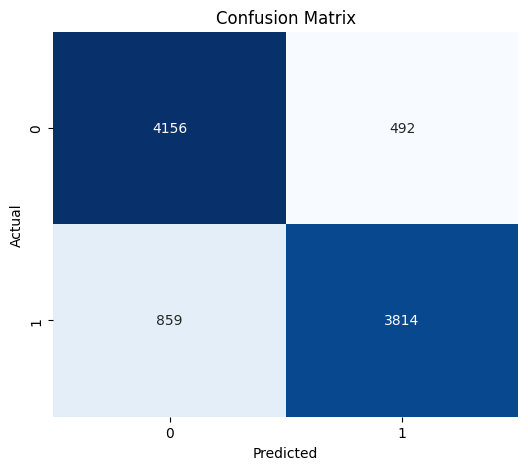

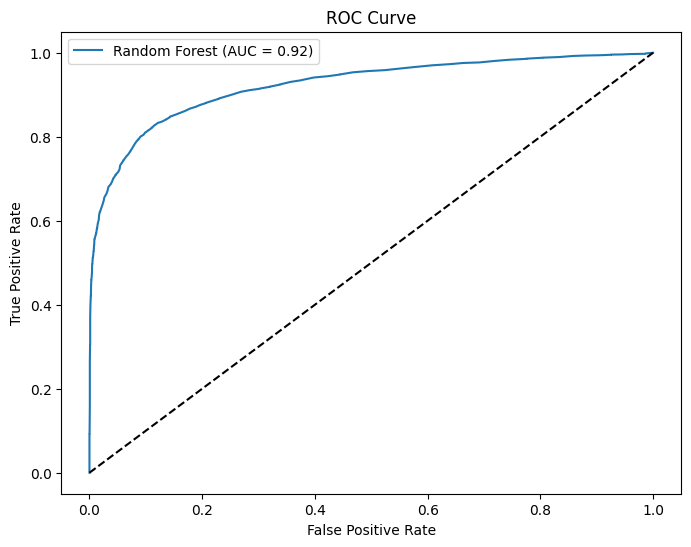

Comparison Summary:
Accuracy Change: -0.0043
Precision Change:-0.0005
F1-Score Change: -0.0052
Recall Change:   -0.0092
AUC-ROC Change:  -0.0030


In [29]:

X_train, X_test, y_train, y_test = train_test_split(X_removed_features, y, test_size=0.2, random_state=42)
print("-" * 50)
print("Training Random Forest on SELECTED Features")
print("-" * 50)
rf_sel = RandomForestClassifier(random_state=42)
rf_sel.fit(X_train, y_train)

y_pred_sel = rf_sel.predict(X_test)
y_prob_sel = rf_sel.predict_proba(X_test)[:, 1]

print("   [Selected Features Results]")
print(f"   Accuracy:  {accuracy_score(y_test, y_pred_sel):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_sel):.4f}")
print(f"   F1-Score:  {f1_score(y_test, y_pred_sel):.4f}")
print(f"   Recall:    {recall_score(y_test, y_pred_sel):.4f}")
print(f"   AUC-ROC:   {roc_auc_score(y_test, y_prob_sel):.4f}")

# Cross-Validation
cv_scores = cross_val_score(rf_sel, X_train, y_train, cv=5, scoring='f1')
print(f"\n5-Fold CV F1-Scores: {cv_scores}")
print(f"Mean CV F1-Score: {cv_scores.mean():.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_sel)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_sel)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_sel):.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Quick Comparison
print("Comparison Summary:")
acc_diff = accuracy_score(y_test, y_pred_sel) - accuracy_score(y_test_full, y_pred_full)
prec_diff = precision_score(y_test, y_pred_sel) - precision_score(y_test_full, y_pred_full)
f1_diff = f1_score(y_test, y_pred_sel) - f1_score(y_test_full, y_pred_full)
recall_diff = recall_score(y_test, y_pred_sel) - recall_score(y_test_full, y_pred_full)
auc_diff = roc_auc_score(y_test, y_prob_sel) - roc_auc_score(y_test_full, y_prob_full)

print(f"Accuracy Change: {acc_diff:+.4f}")
print(f"Precision Change:{prec_diff:+.4f}")
print(f"F1-Score Change: {f1_diff:+.4f}")
print(f"Recall Change:   {recall_diff:+.4f}")
print(f"AUC-ROC Change:  {auc_diff:+.4f}")

Classification Method 2: k-NN

--------------------------------------------------
Training KNN on All features
--------------------------------------------------
   [Full Features Results]
   Accuracy:  0.7877
   Precision: 0.7901
   Recall:    0.7851
   F1-Score:  0.7876
   AUC-ROC:   0.8619

5-Fold CV F1-Scores: [0.78422958 0.7851752  0.78642607 0.79104678 0.78858835]
Mean CV F1-Score: 0.7871


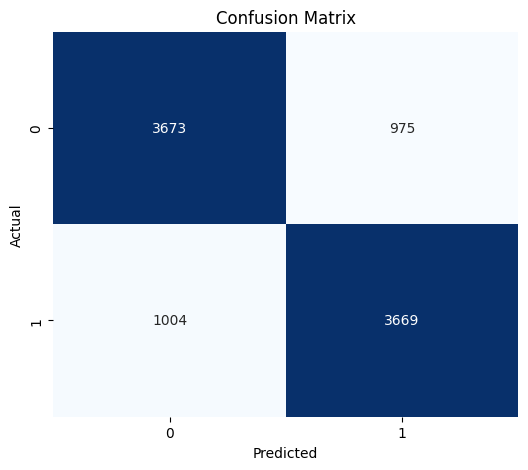

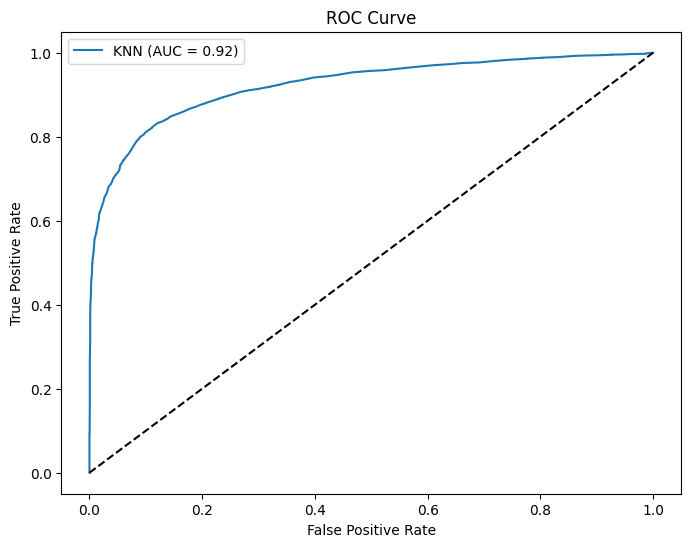

In [30]:
# Split Data
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_Regular, y, test_size=0.2, random_state=42)

# Train & Evaluate on FULL Features
print("-" * 50)
print("Training KNN on All features")
print("-" * 50)
knn_regular = KNeighborsClassifier()
knn_regular.fit(X_train_full, y_train_full)

y_pred_full = knn_regular.predict(X_test_full)
y_prob_full = knn_regular.predict_proba(X_test_full)[:, 1]

print("   [Full Features Results]")
print(f"   Accuracy:  {accuracy_score(y_test_full, y_pred_full):.4f}")
print(f"   Precision: {precision_score(y_test_full, y_pred_full):.4f}")
print(f"   Recall:    {recall_score(y_test_full, y_pred_full):.4f}")
print(f"   F1-Score:  {f1_score(y_test_full, y_pred_full):.4f}")
print(f"   AUC-ROC:   {roc_auc_score(y_test_full, y_prob_full):.4f}")

# Cross-Validation
cv_scores = cross_val_score(knn_regular, X_train_full, y_train_full, cv=5, scoring='f1')
print(f"\n5-Fold CV F1-Scores: {cv_scores}")
print(f"Mean CV F1-Score: {cv_scores.mean():.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test_full, y_pred_full)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_sel)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc_score(y_test, y_prob_sel):.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



The results of kNN were not that impressive.

--------------------------------------------------
Training KNN on SELECTED Features
--------------------------------------------------
   [Selected Features Results]
   Accuracy:  0.7951
   Precision: 0.8018
   F1-Score:  0.7935
   Recall:    0.7854
   AUC-ROC:   0.8683

5-Fold CV F1-Scores: [0.77691575 0.79175091 0.78890392 0.78771479 0.78851882]
Mean CV F1-Score: 0.7868


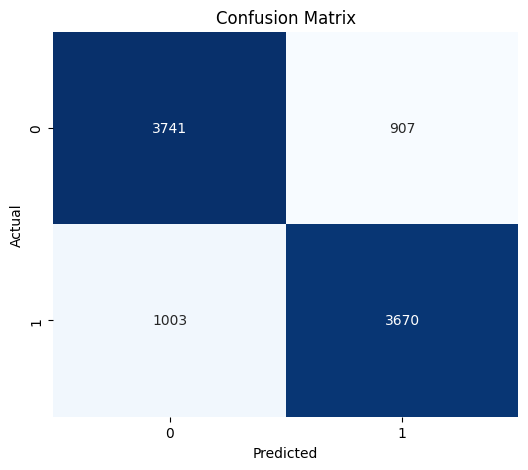

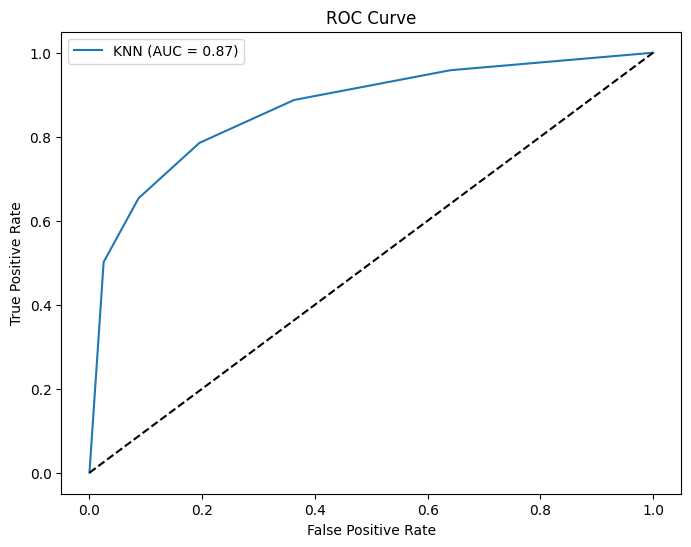

Comparison Summary:
Accuracy Change: +0.0074
Precision Change:+0.0118
F1-Score Change: +0.0059
Recall Change:   +0.0002
AUC-ROC Change:  +0.0065


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_removed_features, y, test_size=0.2, random_state=42)
print("-" * 50)
print("Training KNN on SELECTED Features")
print("-" * 50)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred_sel = knn.predict(X_test)
y_prob_sel = knn.predict_proba(X_test)[:, 1]

print("   [Selected Features Results]")
print(f"   Accuracy:  {accuracy_score(y_test, y_pred_sel):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred_sel):.4f}")
print(f"   F1-Score:  {f1_score(y_test, y_pred_sel):.4f}")
print(f"   Recall:    {recall_score(y_test, y_pred_sel):.4f}")
print(f"   AUC-ROC:   {roc_auc_score(y_test, y_prob_sel):.4f}")

# Cross-Validation
cv_scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1')
print(f"\n5-Fold CV F1-Scores: {cv_scores}")
print(f"Mean CV F1-Score: {cv_scores.mean():.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_sel)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_sel)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc_score(y_test, y_prob_sel):.2f})')
plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Quick Comparison
print("Comparison Summary:")
acc_diff = accuracy_score(y_test, y_pred_sel) - accuracy_score(y_test_full, y_pred_full)
prec_diff = precision_score(y_test, y_pred_sel) - precision_score(y_test_full, y_pred_full)
f1_diff = f1_score(y_test, y_pred_sel) - f1_score(y_test_full, y_pred_full)
recall_diff = recall_score(y_test, y_pred_sel) - recall_score(y_test_full, y_pred_full)
auc_diff = roc_auc_score(y_test, y_prob_sel) - roc_auc_score(y_test_full, y_prob_full)

print(f"Accuracy Change: {acc_diff:+.4f}")
print(f"Precision Change:{prec_diff:+.4f}")
print(f"F1-Score Change: {f1_diff:+.4f}")
print(f"Recall Change:   {recall_diff:+.4f}")
print(f"AUC-ROC Change:  {auc_diff:+.4f}")


Classification Method 3: SVM Linear

LINEAR SVM WITH ALL FEATURES

--- Model Evaluation For Regular---
Accuracy: 0.7698
Precision: 0.8247
Recall: 0.6867
F1-Score: 0.7494
AUC-ROC: 0.8451

5-Fold CV F1-Scores: [0.75715334 0.74896755 0.75521373 0.76070381 0.7541225 ]
Mean CV F1-Score: 0.7552


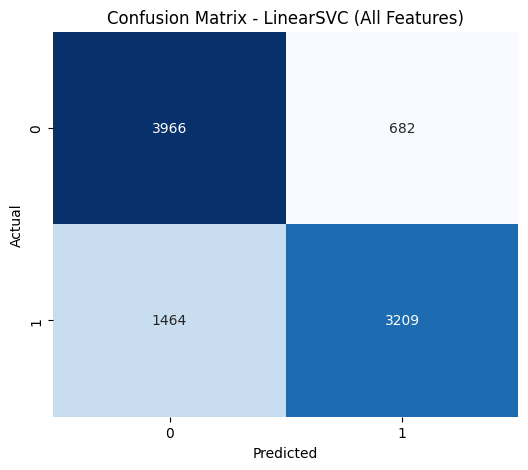

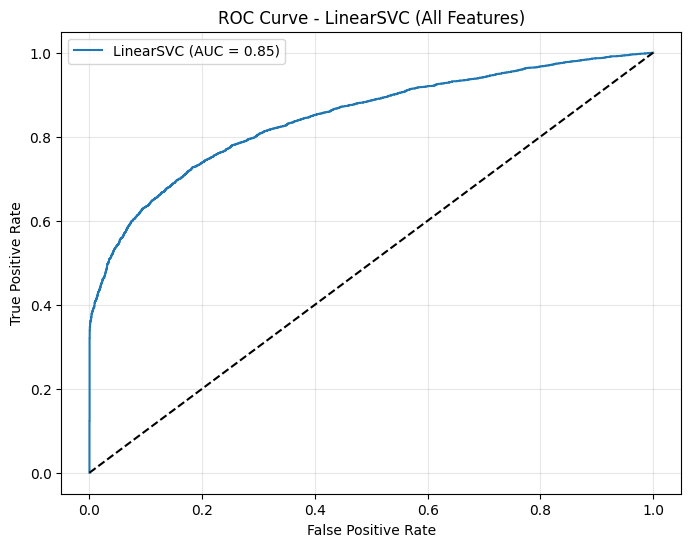

In [32]:

print("="*60)
print("LINEAR SVM WITH ALL FEATURES")
print("="*60)

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_Regular, y, test_size=0.2, random_state=42)

# Create and train LinearSVC
linear_svm_reg = LinearSVC(random_state=42, max_iter=10000)
linear_svm_reg.fit(X_train_full, y_train_full)

# Wrap with CalibratedClassifierCV for probability estimates
calibrated_svm_reg = CalibratedClassifierCV(linear_svm_reg, method='sigmoid', cv=5)
calibrated_svm_reg.fit(X_train_full, y_train_full)

y_pred_full = calibrated_svm_reg.predict(X_test_full)
y_prob_full = calibrated_svm_reg.predict_proba(X_test_full)[:, 1]

print("\n--- Model Evaluation For Regular---")
print(f"Accuracy: {accuracy_score(y_test_full, y_pred_full):.4f}")
print(f"Precision: {precision_score(y_test_full, y_pred_full):.4f}")
print(f"Recall: {recall_score(y_test_full, y_pred_full):.4f}")
print(f"F1-Score: {f1_score(y_test_full, y_pred_full):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test_full, y_prob_full):.4f}")

# Cross-Validation
cv_scores = cross_val_score(linear_svm_reg, X_train_full, y_train_full, cv=5, scoring='f1')
print(f"\n5-Fold CV F1-Scores: {cv_scores}")
print(f"Mean CV F1-Score: {cv_scores.mean():.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test_full, y_pred_full)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LinearSVC (All Features)')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_full, y_prob_full)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LinearSVC (AUC = {roc_auc_score(y_test_full, y_prob_full):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LinearSVC (All Features)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


LINEAR SVM WITH SELECTED FEATURES

--- Model Evaluation For Selected Features---
Accuracy: 0.7701
Precision: 0.8244
Recall: 0.6880
F1-Score: 0.7500
AUC-ROC: 0.8450

5-Fold CV F1-Scores: [0.75796272 0.74819295 0.75470022 0.75912623 0.7527262 ]
Mean CV F1-Score: 0.7545


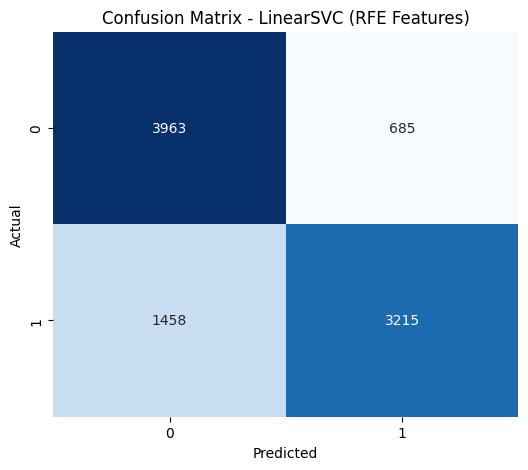

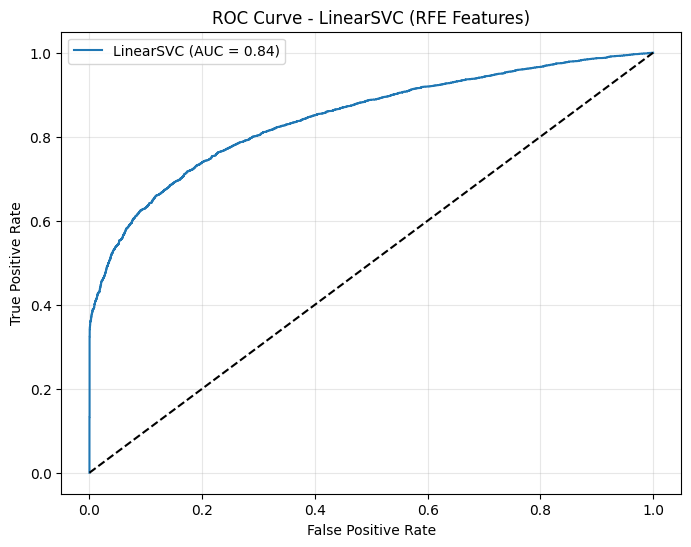

Comparison Summary:
Accuracy Change: +0.0003
Precision Change:-0.0004
F1-Score Change: +0.0006
Recall Change:   +0.0013
AUC-ROC Change:  -0.0001


In [33]:
print("="*60)
print("LINEAR SVM WITH SELECTED FEATURES")
print("="*60)

X_train, X_test, y_train, y_test = train_test_split(X_removed_features, y, test_size=0.2, random_state=42)

# Create and train LinearSVC
linear_svm = LinearSVC(random_state=42, max_iter=10000)
linear_svm.fit(X_train, y_train)

# Wrap with CalibratedClassifierCV for probability estimates
calibrated_svm = CalibratedClassifierCV(linear_svm, method='sigmoid', cv=5)
calibrated_svm.fit(X_train, y_train)

# Make predictions
y_pred_removed = calibrated_svm.predict(X_test)
y_prob_removed = calibrated_svm.predict_proba(X_test)[:, 1]

print("\n--- Model Evaluation For Selected Features---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_removed):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_removed):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_removed):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_removed):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_prob_removed):.4f}")

# Cross-Validation
cv_scores = cross_val_score(linear_svm, X_train, y_train, cv=5, scoring='f1')
print(f"\n5-Fold CV F1-Scores: {cv_scores}")
print(f"Mean CV F1-Score: {cv_scores.mean():.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_removed)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LinearSVC (RFE Features)')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_removed)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LinearSVC (AUC = {roc_auc_score(y_test, y_prob_removed):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LinearSVC (RFE Features)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

acc_diff = accuracy_score(y_test, y_pred_removed) - accuracy_score(y_test_full, y_pred_full)
prec_diff = precision_score(y_test, y_pred_removed) - precision_score(y_test_full, y_pred_full)
f1_diff = f1_score(y_test, y_pred_removed) - f1_score(y_test_full, y_pred_full)
recall_diff = recall_score(y_test, y_pred_removed) - recall_score(y_test_full, y_pred_full)
auc_diff = roc_auc_score(y_test, y_prob_removed) - roc_auc_score(y_test_full, y_prob_full)
print("Comparison Summary:")
print(f"Accuracy Change: {acc_diff:+.4f}")
print(f"Precision Change:{prec_diff:+.4f}")
print(f"F1-Score Change: {f1_diff:+.4f}")
print(f"Recall Change:   {recall_diff:+.4f}")
print(f"AUC-ROC Change:  {auc_diff:+.4f}")

Since SVM non-linear has a time complexity of between O(n^2 *k) to O(n^3 * k) and we have a dataset of over 30000 (After smote) using SVM non-linear is not really efficient since it would take hours to complete. As a result we decided to use SVM linear instead. 

When comparing the performance of SVM linear to the other classifiers, SVM linear does not perform well as hoped as all the scores (accuracy, precision, f1-score, etc) were all lower than the scores from Random Forest and KNN. The performance can be attributed to the dataset not being able to be seperated linear. Testing the feature selection data on linear SVM did not provide any meaningful change as evident from the lack of changes with the scores with the highest change being 0.0013 in recall, which shows that the features removed are not substantially impactful. 

# Hyperparameter Tuning

Grid Search for Classification Method 1: Random Forest

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_removed_features, y, test_size=0.2, random_state=42)

# --- Train Base Model (Before Tuning) ---
print("Training Base Random Forest Model (Default Parameters)...")
# Initialize with default parameters
base_rf = RandomForestClassifier(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_selected_Lasso, y, test_size=0.2, random_state=42)
base_rf.fit(X_train, y_train)

# Predict using Base Model
y_pred_base = base_rf.predict(X_test)
y_prob_base = base_rf.predict_proba(X_test)[:, 1]

# Calculate Base Metrics
base_accuracy = accuracy_score(y_test, y_pred_base)
base_precision = precision_score(y_test,y_pred_base)
base_f1 = f1_score(y_test, y_pred_base)
base_recall = recall_score(y_test,y_pred_base)
base_roc = roc_auc_score(y_test, y_prob_base)

# --- Perform Hyperparameter Tuning (Grid Search) ---
print("Starting Grid Search for Hyperparameter Tuning...")

# Define the parameter grid
# We test different numbers of trees (n_estimators) and depths to find the best balance
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of trees in the forest
    'max_depth': [10, 20, None],          # Max depth of the tree
    'min_samples_split': [2, 5, 10],      # Min samples required to split a node
    'min_samples_leaf': [1, 2, 4]         # Min samples required at a leaf node
}

# Initialize GridSearchCV
# cv=5 means 5-fold Cross-Validation
# n_jobs=-1 uses all available CPU cores to speed up processing
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,          # Lowered to 3 for speed, use 5 for final
                           n_jobs=-1,
                           scoring='f1',  # Optimize for F1 Score (good for imbalance)
                           verbose=2)

# Fit the Grid Search to the training data
grid_search.fit(X_train, y_train)

# Get the best model
best_rf = grid_search.best_estimator_
print(f"Best Parameters Found: {grid_search.best_params_}")


# --- Evaluate Tuned Model ---
print("-" * 30)
print("Evaluating Tuned Random Forest Model...")

# Predict using Tuned Model
y_pred_tuned = best_rf.predict(X_test)
y_prob_tuned = best_rf.predict_proba(X_test)[:, 1]

# Calculate Tuned Metrics
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
tuned_precision = precision_score(y_test, y_pred_tuned)
tuned_f1 = f1_score(y_test, y_pred_tuned)
tuned_recall = recall_score(y_test,y_pred_tuned)
tuned_roc = roc_auc_score(y_test, y_prob_tuned)

print("\n" + "="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)

print(f"\n--- Baseline Model (Default Parameters) ---")
print(f"Accuracy:  {base_accuracy:.4f}")
print(f"Precision: {base_precision:.4f}")
print(f"F1-Score:  {base_f1:.4f}")
print(f"Recall:    {base_recall:.4f}")
print(f"AUC-ROC:   {base_roc:.4f}")

print(f"\n--- Tuned Model (Grid Search Best Parameters) ---")

print(f"Accuracy:  {tuned_accuracy:.4f}")
print(f"Precision: {base_precision:.4f}")
print(f"F1-Score:  {tuned_f1:.4f}")
print(f"Recall:    {tuned_recall:.4f}")
print(f"AUC-ROC:   {tuned_roc:.4f}")

cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='f1')
print(f"\n5-Fold CV F1-Scores: {cv_scores}")
print(f"Mean CV F1-Score: {cv_scores.mean():.4f}")

print("\n" + "="*60)
print("IMPACT OF HYPERPARAMETER TUNING")
print("="*60)
print(f"{'Metric':<12} {'Base Model':<12} {'Tuned Model':<12} {'Improvement':<12}")
print(f"{'-'*48}")
print(f"{'Accuracy':<12} {base_accuracy:.4f}       {tuned_accuracy:.4f}       {tuned_accuracy - base_accuracy:+.4f}")
print(f"{'Precision':<12} {base_precision:.4f}       {tuned_precision:.4f}       {tuned_precision - base_precision:+.4f}")
print(f"{'F1-Score':<12} {base_f1:.4f}       {tuned_f1:.4f}       {tuned_f1 - base_f1:+.4f}")
print(f"{'Recall':<12} {base_recall:.4f}       {tuned_recall:.4f}       {tuned_recall - base_recall:+.4f}")
print(f"{'AUC-ROC':<12} {base_roc:.4f}       {tuned_roc:.4f}       {tuned_roc - base_roc:+.4f}")
print("="*60)

Training Base Random Forest Model (Default Parameters)...
Starting Grid Search for Hyperparameter Tuning...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters Found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
------------------------------
Evaluating Tuned Random Forest Model...

MODEL EVALUATION RESULTS

--- Baseline Model (Default Parameters) ---
Accuracy:  0.8573
Precision: 0.8852
F1-Score:  0.8524
Recall:    0.8220
AUC-ROC:   0.9256

--- Tuned Model (Grid Search Best Parameters) ---
Accuracy:  0.8577
Precision: 0.8852
F1-Score:  0.8533
Recall:    0.8250
AUC-ROC:   0.9263

5-Fold CV F1-Scores: [0.84754235 0.85076085 0.84275494 0.85308848 0.84281311]
Mean CV F1-Score: 0.8474

IMPACT OF HYPERPARAMETER TUNING
Metric       Base Model   Tuned Model  Improvement 
------------------------------------------------
Accuracy     0.8573       0.8577       +0.0004
Precision    0.8852       0.8836       -0.0017
F1-Score     0

Grid/Random Search for Classification Method 2: k-NN

In [35]:

X_train, X_test, y_train, y_test = train_test_split(X_removed_features, y, test_size=0.2, random_state=42)

# --- Perform Hyperparameter Tuning (Grid Search) ---
print("Starting Grid Search for Hyperparameter Tuning...")

param_grid = {
    'n_neighbors': np.arange(3, 10),
    'weights': ['uniform', 'distance'],
    'algorithm': ['kd_tree', 'ball_tree'],
    'leaf_size': np.arange(25, 30)
}

grid_search = GridSearchCV(estimator=KNeighborsClassifier(),
                            param_grid=param_grid,
                            cv=5,
                            n_jobs=-1,
                            scoring='f1',
                            verbose=2)

# Fit the Grid Search to the training data
grid_search.fit(X_train, y_train)

# Get the best model
best_knn = grid_search.best_estimator_
print(f"Best Parameters Found: {grid_search.best_params_}")


# --- Evaluate Tuned Model ---
print("-" * 30)
print("Evaluating Tuned k Nearest Neighbours Model...")

#Get old values
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:, 1]

base_accuracy = accuracy_score(y_test, y_pred)
base_precision = precision_score(y_test,y_pred)
base_f1 = f1_score(y_test, y_pred)
base_recall = recall_score(y_test, y_pred)
base_roc = roc_auc_score(y_test, y_prob)

# Predict using Tuned Model
y_pred_tuned = best_knn.predict(X_test)
y_prob_tuned = best_knn.predict_proba(X_test)[:, 1]

# Calculate Tuned Metrics
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
tuned_precision = precision_score(y_test, y_pred_tuned)
tuned_f1 = f1_score(y_test, y_pred_tuned)
tuned_recall = recall_score(y_test,y_pred)
tuned_roc = roc_auc_score(y_test, y_prob_tuned)


print("\n" + "="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)

print(f"\n--- Baseline Model (Default Parameters) ---")
print(f"Accuracy:  {base_accuracy:.4f}")
print(f"Precision: {base_precision:.4f}")
print(f"F1-Score:  {base_f1:.4f}")
print(f"Recall:    {base_recall:.4f}")
print(f"AUC-ROC:   {base_roc:.4f}")

print(f"\n--- Tuned Model (Grid Search Best Parameters) ---")

print(f"Accuracy:  {tuned_accuracy:.4f}")
print(f"Precision: {tuned_precision:.4f}")
print(f"F1-Score:  {tuned_f1:.4f}")
print(f"Recall:    {tuned_recall:.4f}")
print(f"AUC-ROC:   {tuned_roc:.4f}")

cv_scores = cross_val_score(best_knn, X_train, y_train, cv=5, scoring='f1')
print(f"\n5-Fold CV F1-Scores: {cv_scores}")
print(f"Mean CV F1-Score: {cv_scores.mean():.4f}")


print("\n" + "="*60)
print("IMPACT OF HYPERPARAMETER TUNING")
print("="*60)
print(f"{'Metric':<12} {'Base Model':<12} {'Tuned Model':<12} {'Improvement':<12}")
print(f"{'-'*48}")
print(f"{'Accuracy':<12} {base_accuracy:.4f}       {tuned_accuracy:.4f}       {tuned_accuracy - base_accuracy:+.4f}")
print(f"{'Precision':<12} {base_precision:.4f}       {tuned_precision:.4f}       {tuned_precision - base_precision:+.4f}")
print(f"{'F1-Score':<12} {base_f1:.4f}       {tuned_f1:.4f}       {tuned_f1 - base_f1:+.4f}")
print(f"{'Recall':<12} {base_recall:.4f}       {tuned_recall:.4f}       {tuned_recall - base_recall:+.4f}")
print(f"{'AUC-ROC':<12} {base_roc:.4f}       {tuned_roc:.4f}       {tuned_roc - base_roc:+.4f}")
print("="*60)

Starting Grid Search for Hyperparameter Tuning...
Fitting 5 folds for each of 140 candidates, totalling 700 fits
Best Parameters Found: {'algorithm': 'kd_tree', 'leaf_size': np.int64(25), 'n_neighbors': np.int64(8), 'weights': 'distance'}
------------------------------
Evaluating Tuned k Nearest Neighbours Model...

MODEL EVALUATION RESULTS

--- Baseline Model (Default Parameters) ---
Accuracy:  0.7951
Precision: 0.8018
F1-Score:  0.7935
Recall:    0.7854
AUC-ROC:   0.8683

--- Tuned Model (Grid Search Best Parameters) ---
Accuracy:  0.8144
Precision: 0.8179
F1-Score:  0.8140
Recall:    0.7854
AUC-ROC:   0.8885

5-Fold CV F1-Scores: [0.79876161 0.81336375 0.80705534 0.80959439 0.80485502]
Mean CV F1-Score: 0.8067

IMPACT OF HYPERPARAMETER TUNING
Metric       Base Model   Tuned Model  Improvement 
------------------------------------------------
Accuracy     0.7951       0.8144       +0.0193
Precision    0.8018       0.8179       +0.0161
F1-Score     0.7935       0.8140       +0.0205
Re

Tuning the hyperparameters led to a slight boost in some of the scores but it was nothing too significant.

Grid/Random Search for Classification Method 3: SVM (Linear SVC)

In [36]:
#Grid Search On linear SVM

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_removed_features, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning with Grid Search
print("\n" + "="*60)
print("PERFORMING HYPERPARAMETER TUNING WITH GRID SEARCH")
print("="*60)
C_list = []
for i in range(100):
    C_list.append(i * 0.01 + 0.01)

param_grid = [
    {
        'C': C_list,
        'loss': ['hinge'],
        'penalty': ['l2'],  # hinge only works with l2
        'dual': [True]      # hinge + l2 requires dual=True
    },
    {
        'C': C_list,
        'loss': ['squared_hinge'],
        'penalty': ['l1', 'l2'],
        'dual': [False]    # squared_hinge works with both l1 and l2, use primal
    }
]

grid_search = GridSearchCV(
    estimator=LinearSVC(random_state=42, max_iter=10000),
    param_grid=param_grid,
    cv=5,                   # 5-fold cross-validation
    scoring='f1',           # Optimize for F1-score
    n_jobs=-1,              
    verbose=1               
)

print("Starting Grid Search...")
grid_search.fit(X_train, y_train)
print(f"Best Parameters Found: {grid_search.best_params_}")
best_grid_model = grid_search.best_estimator_

# Wrap best model with CalibratedClassifierCV for probability estimates
calibrated_best = CalibratedClassifierCV(best_grid_model, method='sigmoid', cv=5)
calibrated_best.fit(X_train, y_train)

# Predictions
y_pred_base = calibrated_svm.predict(X_test)
y_prob_base = calibrated_svm.predict_proba(X_test)[:, 1]

y_pred_tuned = calibrated_best.predict(X_test)
y_prob_tuned = calibrated_best.predict_proba(X_test)[:, 1]

# Calculate Metrics
base_accuracy = accuracy_score(y_test, y_pred_base)
base_precision = precision_score(y_test, y_pred_base)
base_f1 = f1_score(y_test, y_pred_base)
base_recall = recall_score(y_test,y_pred_base)
base_roc = roc_auc_score(y_test, y_prob_base)

tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
tuned_precision = precision_score(y_test,y_pred_tuned)
tuned_f1 = f1_score(y_test, y_pred_tuned)
tuned_recall = recall_score(y_test, y_pred_tuned)
tuned_roc = roc_auc_score(y_test, y_prob_tuned)

# Print Results
print("\n" + "="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)

print(f"\n--- Baseline Model (Default Parameters) ---")
print(f"Accuracy:  {base_accuracy:.4f}")
print(f"Precision: {base_precision:.4f}")
print(f"F1-Score:  {base_f1:.4f}")
print(f"Recall:    {base_recall:.4f}")
print(f"AUC-ROC:   {base_roc:.4f}")

print(f"\n--- Tuned Model (Grid Search Best Parameters) ---")

print(f"Accuracy:  {tuned_accuracy:.4f}")
print(f"Precision: {base_precision:.4f}")
print(f"F1-Score:  {tuned_f1:.4f}")
print(f"Recall:    {tuned_recall:.4f}")
print(f"AUC-ROC:   {tuned_roc:.4f}")

cv_scores = cross_val_score(best_grid_model, X_train, y_train, cv=5, scoring='f1')
print(f"\n5-Fold CV F1-Scores: {cv_scores}")
print(f"Mean CV F1-Score: {cv_scores.mean():.4f}")

print("\n" + "="*60)
print("IMPACT OF HYPERPARAMETER TUNING")
print("="*60)
print(f"{'Metric':<12} {'Base Model':<12} {'Tuned Model':<12} {'Improvement':<12}")
print(f"{'-'*48}")
print(f"{'Accuracy':<12} {base_accuracy:.4f}       {tuned_accuracy:.4f}       {tuned_accuracy - base_accuracy:+.4f}")
print(f"{'Precision':<12} {base_precision:.4f}       {tuned_precision:.4f}       {tuned_precision - base_precision:+.4f}")
print(f"{'F1-Score':<12} {base_f1:.4f}       {tuned_f1:.4f}       {tuned_f1 - base_f1:+.4f}")
print(f"{'Recall':<12} {base_recall:.4f}       {tuned_recall:.4f}       {tuned_recall - base_recall:+.4f}")
print(f"{'AUC-ROC':<12} {base_roc:.4f}       {tuned_roc:.4f}       {tuned_roc - base_roc:+.4f}")
print("="*60)


PERFORMING HYPERPARAMETER TUNING WITH GRID SEARCH
Starting Grid Search...
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Best Parameters Found: {'C': 0.06999999999999999, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}

MODEL EVALUATION RESULTS

--- Baseline Model (Default Parameters) ---
Accuracy:  0.7701
Precision: 0.8244
F1-Score:  0.7500
Recall:    0.6880
AUC-ROC:   0.8450

--- Tuned Model (Grid Search Best Parameters) ---
Accuracy:  0.7697
Precision: 0.8244
F1-Score:  0.7508
Recall:    0.6923
AUC-ROC:   0.8446

5-Fold CV F1-Scores: [0.75749559 0.74808033 0.75485689 0.76064611 0.75173534]
Mean CV F1-Score: 0.7546

IMPACT OF HYPERPARAMETER TUNING
Metric       Base Model   Tuned Model  Improvement 
------------------------------------------------
Accuracy     0.7701       0.7697       -0.0004
Precision    0.8244       0.8202       -0.0041
F1-Score     0.7500       0.7508       +0.0008
Recall       0.6880       0.6923       +0.0043
AUC-ROC      0.8450       

The lack of change from hyperparameter tuning for SVM implies that the linear decision boundary created from Linear SVC is already optimal with its default parameters (C = 1.0). Based on the results it is safe to believe that a linear model may not be powerful enough for predict whether a customer defaults since the dataset be seperated by a linear boundary.